# YoloV5 ONNX inference example

Can reference the [link](https://github.com/ultralytics/yolov5/issues/343#issuecomment-658021043). It's a really interesting discussion thread about YoloV5 ONNX detection.

# Prepare environment and lib path

In [1]:
# run 0-yolov5-onnx to generate the onnx model
!rm ./yolov5s.onnx
!cp ../0-yolov5-onnx/yolov5s.onnx .

In [ ]:
!pip install onnxruntime torch torchvision --upgrade
# !pip install onnxruntime     # CPU build
# pip install onnxruntime-gpu   # GPU build

In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [2]:
# extend yolov5 python lib path
import os, sys
fp_yolov5 = os.path.abspath(os.getcwd()) + "/yolov5"
sys.path.append(fp_yolov5)
sys.path

['',
 '/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python36.zip',
 '/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6',
 '/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/lib-dynload',
 '/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages',
 '/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/extensions',
 '/home/ec2-user/.ipython',
 '/home/ec2-user/SageMaker/myAWSStudyBlog/sagemaker-greengrass/1-yolov5-onnx-inference/yolov5']

In [3]:
import onnxruntime
import numpy as np
from numpy import asarray
from PIL import Image

In [4]:
# import yolov5 utils
from utils.datasets import *
from utils.utils import *

# Experiement Image Helper script for letterbox

In [5]:
fp_img = fp_yolov5 + '/inference/images/zidane.jpg'

img_pil = Image.open(fp_img)
# display(img_pil)

# convert image to numpy array
img_np = np.array(img_pil)
print('np shape: {} (H, W, C)'.format(img_np.shape))
print('PIL image size: {} (W, H)'.format(img_pil.size))

np shape: (720, 1280, 3) (H, W, C)
PIL image size: (1280, 720) (W, H)


In [6]:
# verify the transpose HWC -> CHW
x = np.ones((720, 1280, 3))
print(f'np shape: {x.shape} (H, W, C)')
print(f'yolo np shape: {np.transpose(x, (2, 0, 1)).shape} (C, H, W)')

np shape: (720, 1280, 3) (H, W, C)
yolo np shape: (3, 720, 1280) (C, H, W)


In [7]:
desired_size = 640, 640
img_pil.thumbnail(desired_size)
new_size = img_pil.size
print(new_size)
# display(img_pil)

(640, 360)


(640, 640)


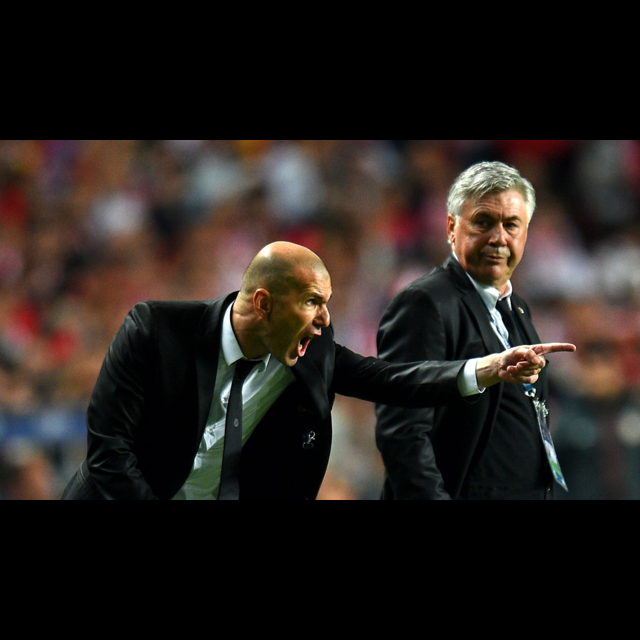

In [8]:
img_padding = Image.new("RGB", desired_size)
img_padding.paste(img_pil, ((desired_size[0]-new_size[0])//2, (desired_size[1]-new_size[1])//2))
print(img_padding.size)
display(img_padding)

# Define the image_letterbox function

In [9]:
from PIL import Image

def image_letterbox(fp_image, desired_size):
    img_pil = Image.open(fp_img)
    # resize inplace to save memory
    img_pil.thumbnail(desired_size)
    new_size = img_pil.size
    img_padding = Image.new("RGB", desired_size)
    img_padding.paste(img_pil, ((desired_size[0]-new_size[0])//2, (desired_size[1]-new_size[1])//2))
    return img_padding

In [10]:
fp_onnx = './yolov5s.onnx'
session = onnxruntime.InferenceSession(fp_onnx)
session.get_modelmeta()
first_input_name = session.get_inputs()[0].name
first_output_name = session.get_outputs()[0].name

print(f'input_name:{first_input_name} output_name:{first_output_name}')

input_name:images output_name:output


In [11]:
def detect_onnx(fp_onnx, image_path=None):
    num_classes = 80
    anchors = [[116, 90, 156, 198, 373, 326], [30, 61, 62, 45, 59, 119], [10, 13, 16, 30, 33, 23]]  # 5s

    session = onnxruntime.InferenceSession(fp_onnx)
    # print("The model expects input shape: ", session.get_inputs()[0].shape)
    batch_size = session.get_inputs()[0].shape[0]
    img_size_h = session.get_inputs()[0].shape[2]
    img_size_w = session.get_inputs()[0].shape[3]

    # input
    im_letterbox = image_letterbox(fp_img, (img_size_w, img_size_h))
    # convert image to numpy array
    np_image = asarray(im_letterbox)
    img_in = np.transpose(np_image, (2, 0, 1)).astype(np.float32)  # HWC -> CHW
    img_in = np.expand_dims(img_in, axis=0)
    img_in /= 255.0
    print("Shape of the image input shape: ", img_in.shape)

    # inference
    input_name = session.get_inputs()[0].name
    outputs = session.run(None, {input_name: img_in})

    batch_detections = []
    print(f'output len: {len(outputs)} outputs[0] shape: {outputs[0].size}')
    
    batch_detections = torch.from_numpy(np.array(outputs[0]))
    batch_detections = non_max_suppression(batch_detections, conf_thres=0.5, iou_thres=0.6, agnostic=False)
    return batch_detections


In [12]:
fp_onnx = './yolov5s.onnx'
fp_img = fp_yolov5 + '/inference/images/zidane.jpg'
response = detect_onnx(fp_onnx=fp_onnx, image_path=fp_img)
response

Shape of the image input shape:  (1, 3, 640, 640)
output len: 3 outputs[0] shape: 102000


[tensor([[ 0.81161, -0.47508,  0.27452, -0.42610, 10.68654,  0.00000],
         [ 0.38914, -0.78357,  0.67070, -0.13368,  9.83339,  0.00000],
         [ 0.17634, -2.26260,  0.83459,  1.40140,  8.82098,  0.00000],
         [ 0.25610,  1.95300,  0.50970,  2.59941,  6.46001,  0.00000],
         [ 0.66437,  2.21587,  0.10804,  2.26155,  6.45010,  0.00000],
         [-1.48306, -0.46049, -1.99117, -0.41269,  6.01910,  0.00000],
         [ 0.05037,  0.47176,  0.68107,  3.86107,  5.74681,  0.00000],
         [ 0.14579,  0.13009,  0.33259, -0.10103,  3.77203,  0.00000],
         [-0.63067, -0.12942,  1.05445,  0.14537,  3.55999,  0.00000],
         [-1.87452, -0.77079, -1.55343, -0.12250,  3.44013,  0.00000],
         [-2.18143, -2.19045, -1.46298,  1.34771,  2.33854,  0.00000]])]

In [ ]:
# def detect_onnx(official=True, image_path=None):
#     num_classes = 80
#     anchors = [[116, 90, 156, 198, 373, 326], [30, 61, 62, 45, 59, 119], [10, 13, 16, 30, 33, 23]]  # 5s

#     session = onnxruntime.InferenceSession(fp_onnx)
#     # print("The model expects input shape: ", session.get_inputs()[0].shape)
#     batch_size = session.get_inputs()[0].shape[0]
#     img_size_h = session.get_inputs()[0].shape[2]
#     img_size_w = session.get_inputs()[0].shape[3]

#     # input
#     im_letterbox = image_letterbox(fp_img, (img_size_w, img_size_h))
#     # convert image to numpy array
#     np_image = asarray(im_letterbox)
# #     print(np_image.shape)

#     # image_src = Image.open(image_path)
#     # resized = letterbox_image(image_src, (img_size_w, img_size_h))
#     # convert image to numpy array
# #     np_image = asarray(image_src)
# #     print(np_image.shape)
    
# #     resized = letterbox(np_image, (img_size_w, img_size_h))

# #     print(resized.shape)    
#     img_in = np.transpose(np_image, (2, 0, 1)).astype(np.float32)  # HWC -> CHW
#     img_in = np.expand_dims(img_in, axis=0)
#     img_in /= 255.0
#     print("Shape of the image input shape: ", img_in.shape)

#     # inference
#     input_name = session.get_inputs()[0].name
#     outputs = session.run(None, {input_name: img_in})

#     batch_detections = []
#     if official and len(outputs) == 4:   # model.model[-1].export = boolean ---> True:3 False:4
#         # model.model[-1].export = False ---> outputs[0] (1, xxxx, 85)
#         # official
#         batch_detections = torch.from_numpy(np.array(outputs[0]))
#         batch_detections = non_max_suppression(batch_detections, conf_thres=0.4, iou_thres=0.5, agnostic=False)
#     else:
#         # model.model[-1].export = False ---> outputs[1]/outputs[2]/outputs[2]
#         # model.model[-1].export = True  ---> outputs
#         # (1, 3, 20, 20, 85)
#         # (1, 3, 40, 40, 85)
#         # (1, 3, 80, 80, 85)
#         # myself (from yolo.py Detect)
#         boxs = []
#         a = torch.tensor(anchors).float().view(3, -1, 2)
#         anchor_grid = a.clone().view(3, 1, -1, 1, 1, 2)
#         if len(outputs) == 4:
#             outputs = [outputs[1], outputs[2], outputs[3]]
#         for index, out in enumerate(outputs):
#             out = torch.from_numpy(out)
#             batch = out.shape[1]
#             feature_w = out.shape[2]
#             feature_h = out.shape[3]

#             # Feature map corresponds to the original image zoom factor
#             stride_w = int(img_size_w / feature_w)
#             stride_h = int(img_size_h / feature_h)

#             conf = out[..., 4]
#             pred_cls = out[..., 5:]

#             grid_x, grid_y = np.meshgrid(np.arange(feature_w), np.arange(feature_h))

#             # cx, cy, w, h
#             pred_boxes = torch.FloatTensor(out[..., :4].shape)
#             pred_boxes[..., 0] = (torch.sigmoid(out[..., 0]) * 2.0 - 0.5 + grid_x) * stride_w  # cx
#             pred_boxes[..., 1] = (torch.sigmoid(out[..., 1]) * 2.0 - 0.5 + grid_y) * stride_h  # cy
#             pred_boxes[..., 2:4] = (torch.sigmoid(out[..., 2:4]) * 2) ** 2 * anchor_grid[index]  # wh

#             conf = torch.sigmoid(conf)
#             pred_cls = torch.sigmoid(pred_cls)

#             output = torch.cat((pred_boxes.view(batch_size, -1, 4),
#                                 conf.view(batch_size, -1, 1),
#                                 pred_cls.view(batch_size, -1, num_classes)),
#                                -1)
#             boxs.append(output)

#         outputx = torch.cat(boxs, 1)
#         # NMS
#         batch_detections = w_non_max_suppression(outputx, num_classes, conf_thres=0.4, nms_thres=0.3)

#     return batch_detections